<a href="https://colab.research.google.com/github/sbooeshaghi/azucar/blob/main/analysis/293T/obs2/norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip install --quiet -U upsetplot scikit-learn git+http://github.com/dirguis/ipfn@master

In [41]:
!git clone https://github.com/sbooeshaghi/azucar.git

fatal: destination path 'azucar' already exists and is not an empty directory.


In [42]:
#@title import
import os
from ipfn import ipfn
import matplotlib.pyplot as plt
from sklearn.metrics import rand_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from collections import defaultdict
from scipy.io import mmread, mmwrite
from scipy.sparse import csr_matrix
from sklearn.neighbors import KDTree
from scipy.stats import entropy
from itertools import combinations
import sys
import gzip
from scipy.stats import entropy
from sklearn.mixture import GaussianMixture


def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

from upsetplot import from_memberships, plot as upsetplot, from_contents

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [43]:
#@title mx norm
def do_ipf(mtx, axis_uniform = 1):
  rows, cols = mtx.shape

  n = 1
  if axis_uniform == 1:
    aggregates = [
                  np.ones(rows)*n/rows, # rows, each cell uniform
                  nd(mtx.sum(0))/mtx.sum() # columns, each tag proportional
                  ]
  elif axis_uniform == 0:
    aggregates = [
                  nd(mtx.sum(1))/mtx.sum(), # rows, each cell proportional
                  np.ones(cols)*n/cols, # columns, each tag uniform
                  ]
  elif axis_uniform == -1:
    aggregates = [
                  np.ones(rows)*n/rows, # rows, each cell uniform,
                  np.ones(cols)*n/cols, # columns, each tag uniform
                  ]
  dimensions = [[0], [1]]

  IPF = ipfn.ipfn(mtx, aggregates, dimensions, max_iteration=100_000)
  m = IPF.iteration()
  return m

def mx_norm(matrix_fn, out_matrix_fn, how="ipf"):
  mtx = mmread(matrix_fn).toarray()
  
  if how == "ipf":
    mtx_ipf = do_ipf(mtx.copy(), axis_uniform=1) # 0: uniform cols, 1: uniform rows, -1: both uniform
    mmwrite(out_matrix_fn, csr_matrix(mtx_ipf*mtx.sum()))
  elif how == "log1p":
    log1p = np.log1p(mtx)
    mtx_log1p = csr_matrix(log1p)
    mmwrite(out_matrix_fn, mtx_log1p)

def read_str_list(fname, lst=list):
  with open(fname, 'r') as f:
    for idx, line in enumerate(f.readlines()):
      lst.append(line.strip())

In [44]:
sample = "293T"
observation = "obs2"

base_data = f"azucar/analysis/{sample}/{observation}/out"
base_mark = f"azucar/analysis/{sample}/{observation}/assign"

matrix_fn  = os.path.join(base_data, "matrix.mtx")
genes_fn   = os.path.join(base_data, "genes.txt")
barcodes_fn   = os.path.join(base_data, "barcodes.txt")

!gunzip $base_data/*.gz

gzip: azucar/analysis/293T/obs2/out/*.gz: No such file or directory


In [45]:
genes = []
read_str_list(genes_fn, genes)
ngenes = len(genes)

In [56]:
# ipf
mx_norm(matrix_fn, "./norm.matrix.mtx", how="ipf")

# log1p -> ipf
mx_norm(matrix_fn, "./log1p.matrix.mtx", how="log1p"); mx_norm("./log1p.matrix.mtx", "./log1p.norm.matrix.mtx", how="ipf")

# ipf -> log1p
mx_norm(matrix_fn, "./norm.matrix.mtx", how="ipf"); mx_norm("./norm.matrix.mtx", "./norm.log1p.matrix.mtx", how="log1p")

In [57]:
mtx = mmread(matrix_fn).toarray()
mtx_norm = mmread("norm.matrix.mtx").toarray()

mtx_log1p = mmread("log1p.matrix.mtx").toarray()
mtx_log1p_norm = mmread("log1p.norm.matrix.mtx").toarray()

mtx_norm_log1p = mmread("norm.log1p.matrix.mtx").toarray()

In [48]:
print("mtx:            ", mtx.sum(0).astype(int))
print("mtx_norm:       ", mtx_norm.sum(0).astype(int))
print("mtx_log1p:      ", mtx_log1p.sum(0).astype(int))
print("mtx_log1p_norm: ", mtx_log1p_norm.sum(0).astype(int))

mtx:             [ 481404  191131 2811662  630216  170928]
mtx_norm:        [ 481404  191130 2811661  630215  170928]
mtx_log1p:       [ 63422  36345 132300  80619  30886]
mtx_log1p_norm:  [ 63422  36345 132300  80619  30886]


In [49]:
print("mtx:            ", mtx.sum(1).astype(int))
print("mtx_norm:       ", mtx_norm.sum(1).astype(int))
print("mtx_log1p:      ", mtx_log1p.sum(1).astype(int))
print("mtx_log1p_norm: ", mtx_log1p_norm.sum(1).astype(int))

mtx:             [ 72  79  71 ...  73 113 207]
mtx_norm:        [132 132 132 ... 132 132 132]
mtx_log1p:       [10  9  9 ... 10 11  5]
mtx_log1p_norm:  [10 10 10 ... 10 10 10]


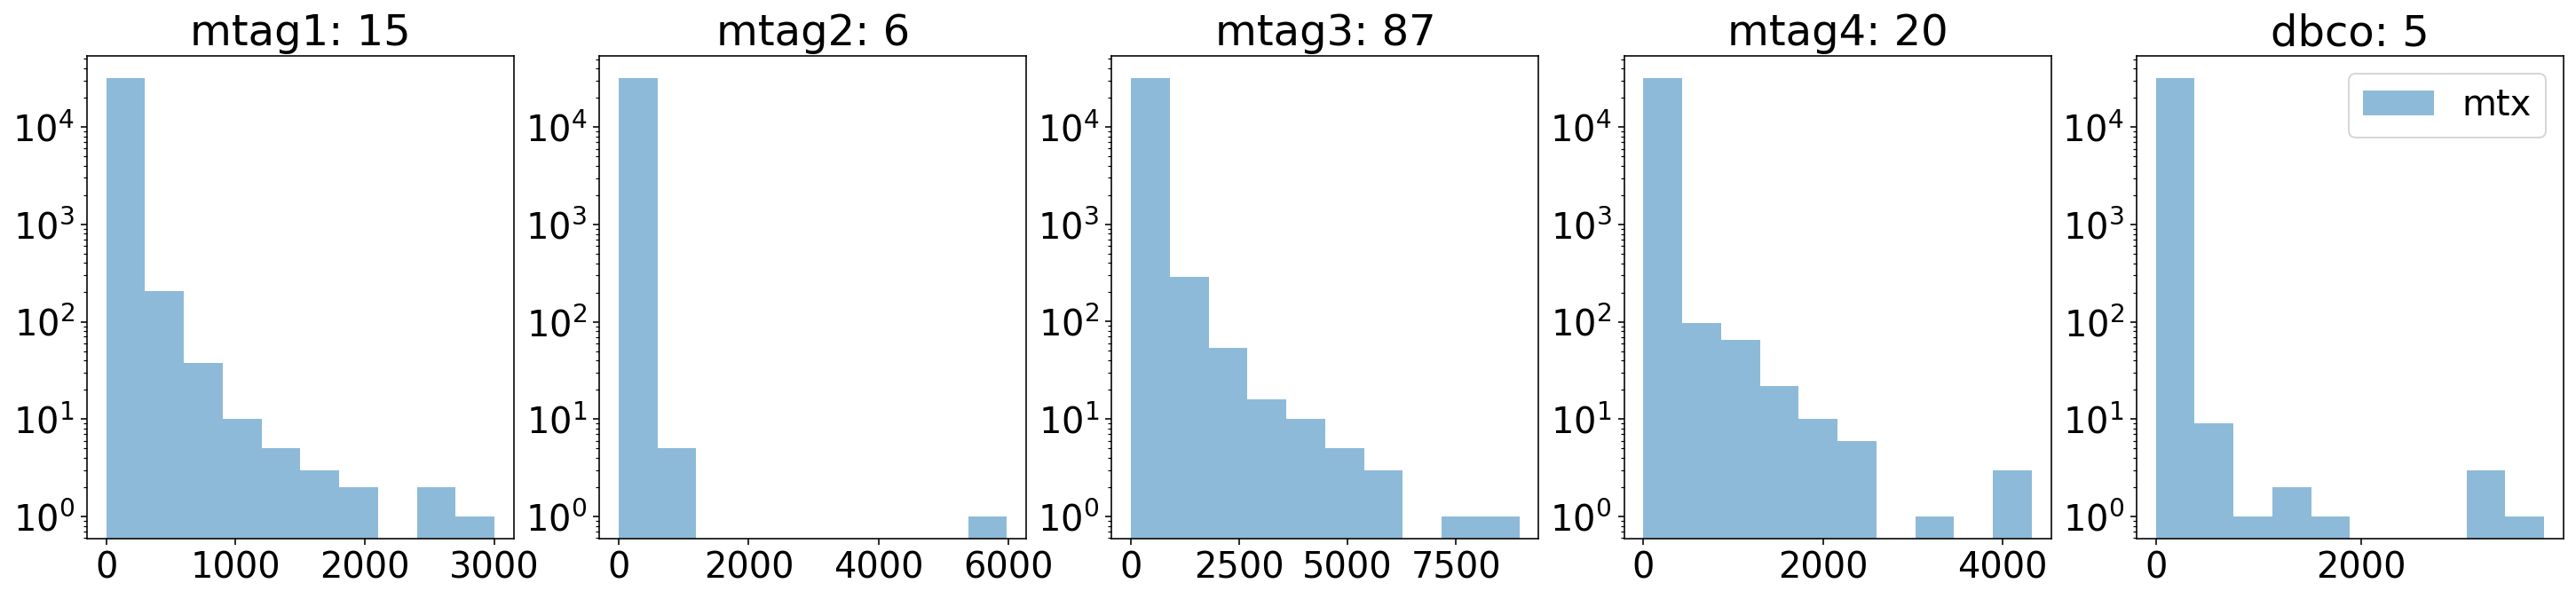

In [50]:
fig, axs = plt.subplots(figsize=(5*ngenes,5), ncols=ngenes)

for idx, ax in enumerate(axs):
  ax.hist(mtx[:,idx], label="mtx", alpha=0.5)
  #ax.hist(mtx_norm[:,idx].astype(int), label="norm", alpha=0.5)
  ax.set(**{
      "yscale": "log",
      "title": f"{genes[idx]}: {mtx_norm[:,idx].mean():,.0f}"
  })

ax.legend()

fig.show()

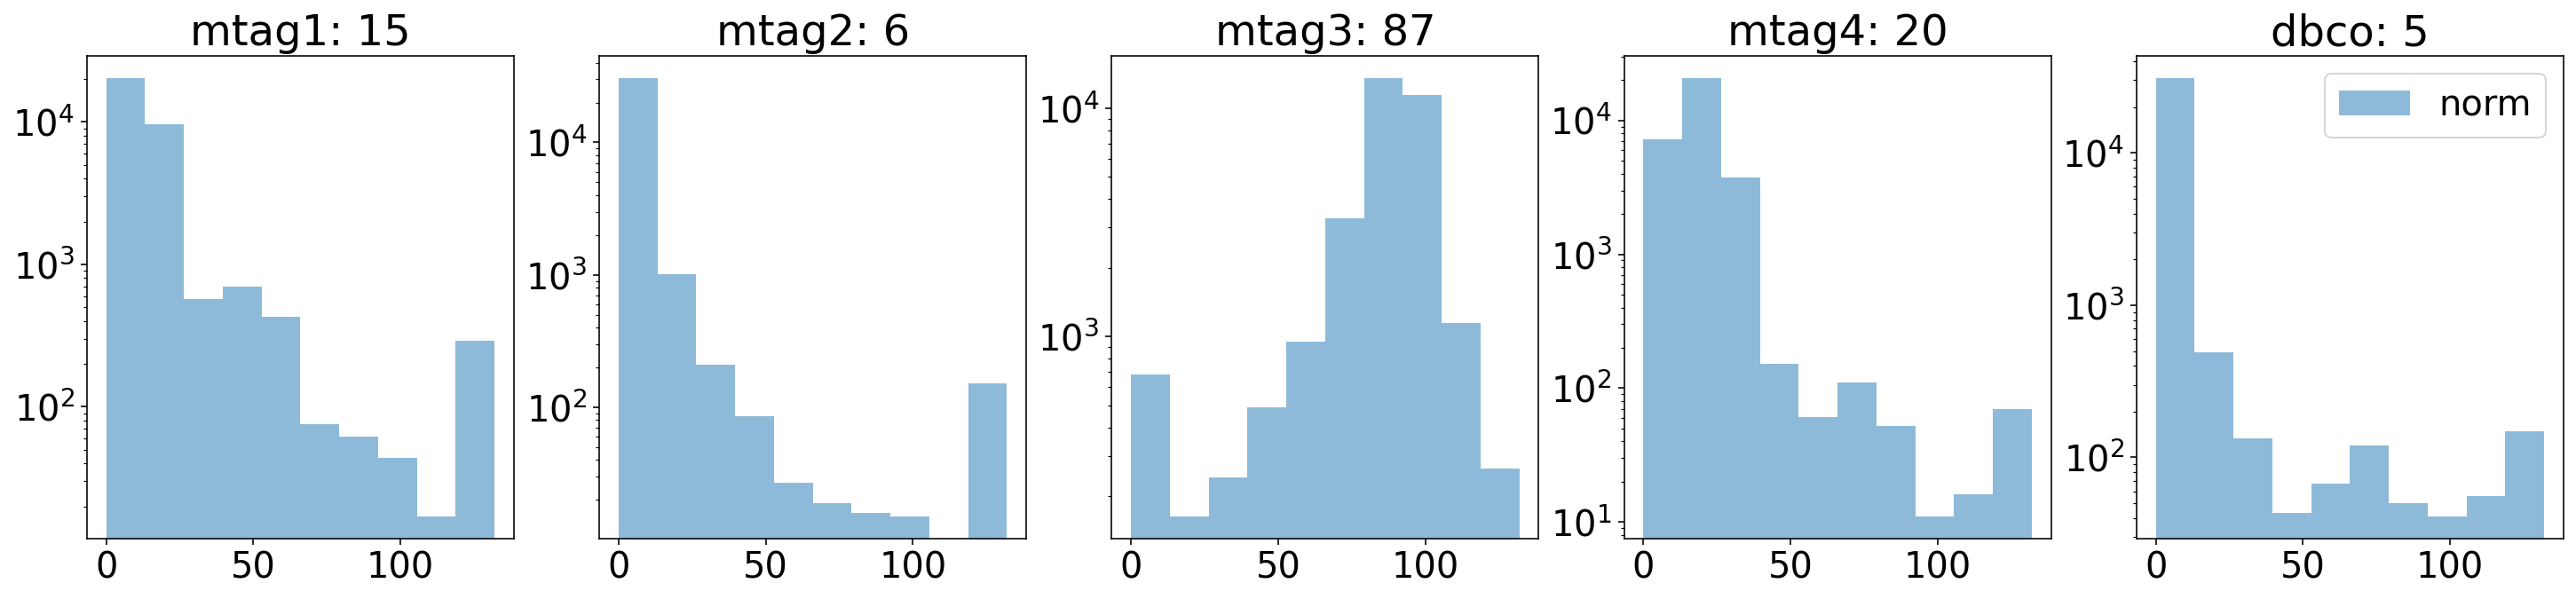

In [55]:
fig, axs = plt.subplots(figsize=(5*ngenes,5), ncols=ngenes)

for idx, ax in enumerate(axs):
  #ax.hist(mtx[:,idx], label="mtx", alpha=0.5)
  ax.hist(mtx_norm[:,idx].astype(int), label="norm", alpha=0.5)
  ax.set(**{
      "yscale": "log",
      "title": f"{genes[idx]}: {mtx_norm[:,idx].mean():,.0f}"
  })

ax.legend()

fig.show()

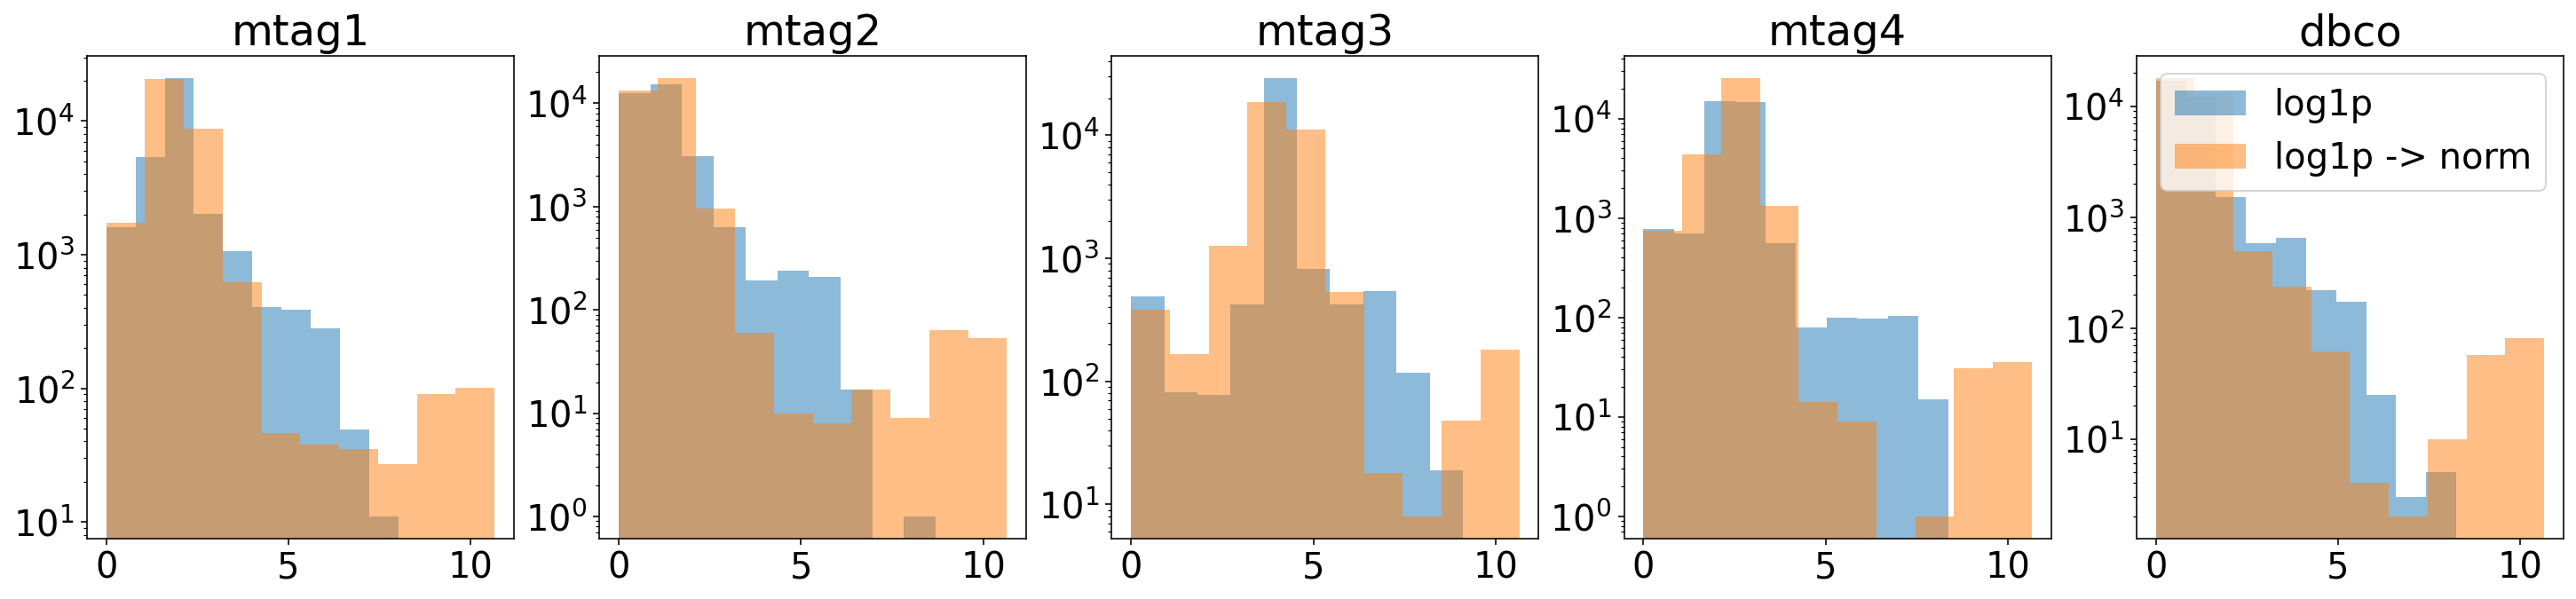

In [58]:
fig, axs = plt.subplots(figsize=(5*ngenes,5), ncols=ngenes)

for idx, ax in enumerate(axs):
  ax.hist(mtx_log1p[:,idx], label="log1p", alpha=0.5)
  ax.hist(mtx_log1p_norm[:,idx], label="log1p -> norm", alpha=0.5)
  ax.set(**{
      "yscale": "log",
      "title": genes[idx]
  })

ax.legend()

fig.show()

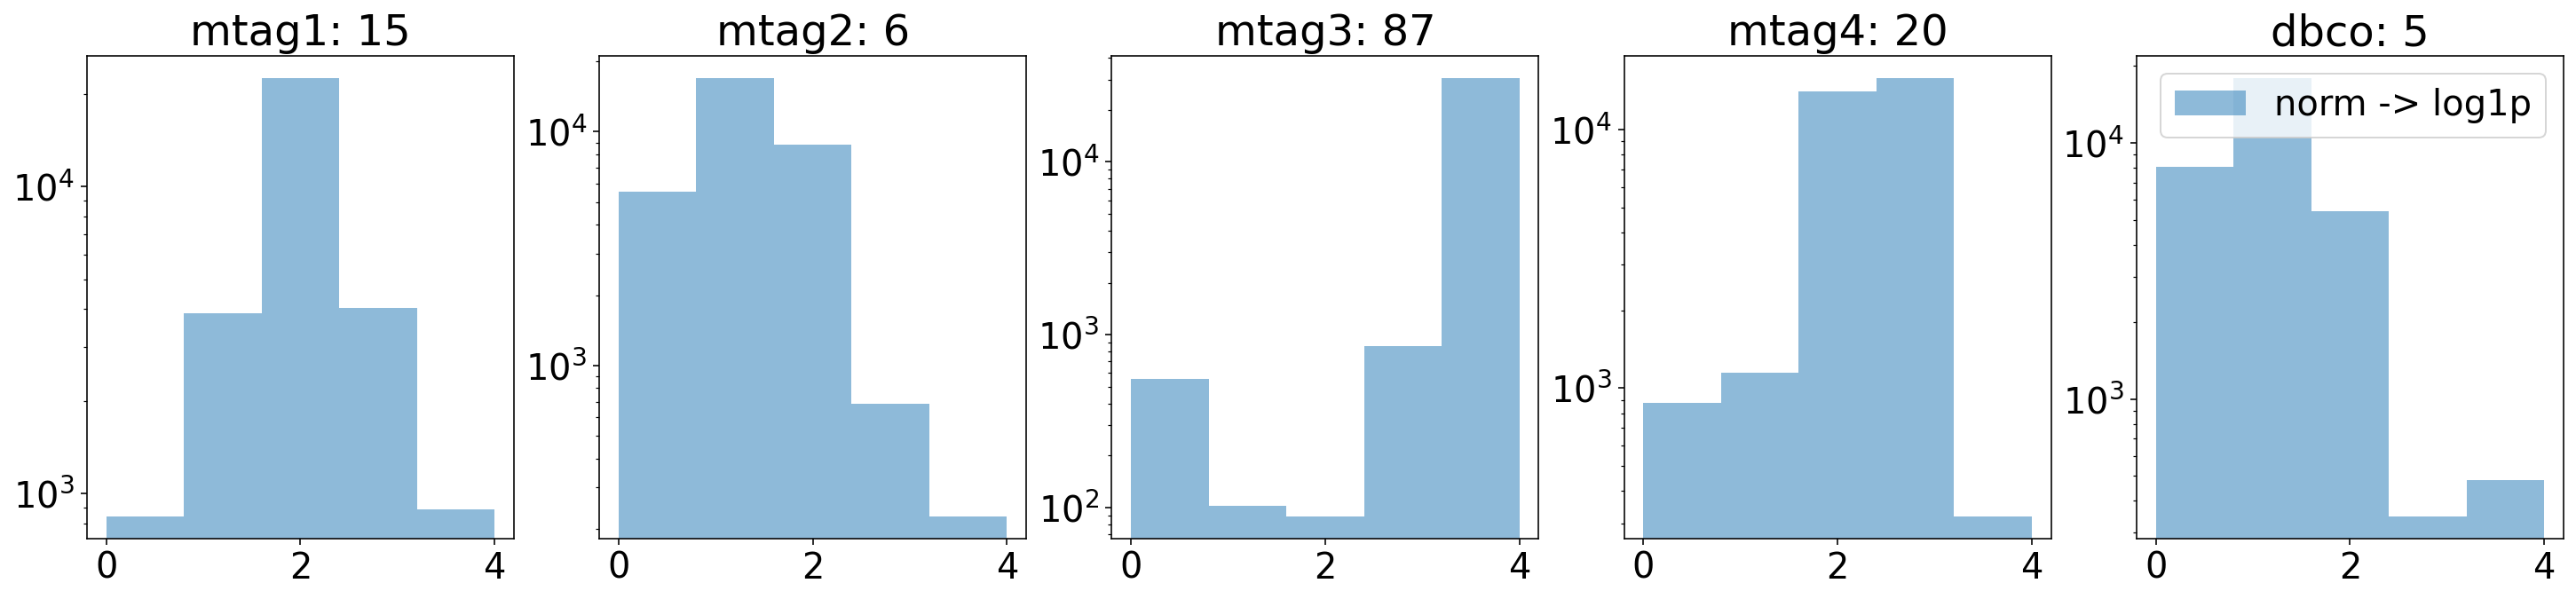

In [61]:
fig, axs = plt.subplots(figsize=(5*ngenes,5), ncols=ngenes)

for idx, ax in enumerate(axs):
  ax.hist(mtx_norm_log1p[:,idx].astype(int), label="norm -> log1p", alpha=0.5, bins=5)
  ax.set(**{
      "yscale": "log",
      "title": f"{genes[idx]}: {mtx_norm[:,idx].mean():,.0f}"
  })

ax.legend()

fig.show()

In [52]:
mtx[:,0].sum()

481404.0

In [53]:
mtx_norm[:,0].astype(int).sum()

465637